This code intends to perform XG-boost based machine learning feature selection to identify top clinical variables 
that are highly correlated with the sruvival time of the patients. 

Written by Yuncong Mao in December 2024

In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

     |████████████████████████████████| 1.3 MB 3.2 MB/s            


Duplicate key in file '/Users/tobymao/.matplotlib/matplotlibrc', line 2 ('backend: TkAgg')


In [ ]:
data = pd.read_csv('/Users/tobymao/Desktop/neuro research/neuro-onc research/clinical_cov/clean.csv')
y = data['SurvFromDx(mo)']
data.head()


,Sex,Race,Ethnicity,Age,MRN,ER Admit,CASE PRIMARY PROCEDURE PANEL 1,CASE CLASSIFICATION,ADMISSION TYPE,Path-Confirmed Diagnosis,...,Avastin,Gliadel,Number Gliadel,Other Chemo,TypeofRad,RadDose(Gy),Immunotherapy,Death,Recurrence,SurvFromDx(mo)
0,1,0,0,75,1,0,Craniotomy For Tumor Adult,1,1,4,...,0.0,0.0,0.0,0.0,2.0,2800.0,0.0,0,0.0,20.533333
1,1,0,0,74,2,1,Craniotomy For Tumor Adult,3,3,4,...,0.0,1.0,8.0,0.0,2.0,3200.0,0.0,1,0.0,8.533333
2,0,0,0,62,3,0,Craniotomy For Tumor Adult,1,1,4,...,0.0,0.0,0.0,0.0,2.0,5040.0,0.0,0,0.0,11.533333
3,1,0,0,76,4,0,Craniotomy For Tumor Adult,1,1,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,1.533333
4,0,0,0,50,5,0,Craniotomy For Tumor Adult,1,1,4,...,1.0,0.0,0.0,0.0,2.0,6000.0,0.0,0,0.0,7.166667


Drop variables that are not conducive to the analysis

In [6]:
data = data.drop(['SurvFromDx(mo)', 'MRN', 'CASE PRIMARY PROCEDURE PANEL 1'], axis=1, errors='ignore')
data.head()

,Sex,Race,Ethnicity,Age,ER Admit,CASE CLASSIFICATION,ADMISSION TYPE,Path-Confirmed Diagnosis,IDH+,OLIG2,...,AdjTMZ,Avastin,Gliadel,Number Gliadel,Other Chemo,TypeofRad,RadDose(Gy),Immunotherapy,Death,Recurrence
0,1,0,0,75,0,1,1,4,0,0,...,0.0,0.0,0.0,0.0,0.0,2.0,2800.0,0.0,0,0.0
1,1,0,0,74,1,3,3,4,0,0,...,2.0,0.0,1.0,8.0,0.0,2.0,3200.0,0.0,1,0.0
2,0,0,0,62,0,1,1,4,0,0,...,0.0,0.0,0.0,0.0,0.0,2.0,5040.0,0.0,0,0.0
3,1,0,0,76,0,1,1,4,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0
4,0,0,0,50,0,1,1,4,0,0,...,0.0,1.0,0.0,0.0,0.0,2.0,6000.0,0.0,0,0.0


Drop columns with higher than 30% missing values, which are ['Eloquence', 'Discrepancy Between Rad/Path', 'ASA Score', 'Blood loss',
       'GermanOphthalmScore']

Percentage of missing values in each column:
Sex               0.000000
Race              0.000000
Ethnicity         0.000000
Age               0.000000
ER Admit          0.000000
                   ...    
TypeofRad         5.844156
RadDose(Gy)      11.428571
Immunotherapy    11.298701
Death             0.000000
Recurrence        0.779221
Length: 110, dtype: float64


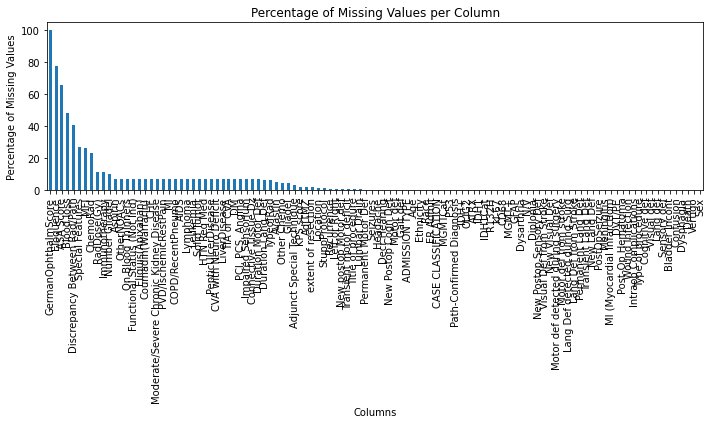

Columns with more than 30% missing values:
Index(['Eloquence', 'Discrepancy Between Rad/Path', 'ASA Score', 'Blood loss',
       'GermanOphthalmScore'],
      dtype='object')
65.84415584415585


In [ ]:
missing_percentages = data.isnull().mean() * 100
print("Percentage of missing values in each column:")
print(missing_percentages)
plt.figure(figsize=(10, 6))
missing_percentages.sort_values(ascending=False).plot(kind='bar')
plt.title('Percentage of Missing Values per Column')
plt.xlabel('Columns')
plt.ylabel('Percentage of Missing Values')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()
high_missing_columns = missing_percentages[missing_percentages > 30].index
print("Columns with more than 30% missing values:")
print(high_missing_columns)
print(missing_percentages['ASA Score'])
data = data.drop(columns=high_missing_columns, errors='ignore')

Fill in missing values with 0, XG_Boost handles this. See Statsquest "https://www.youtube.com/watch?v=GrJP9FLV3FE"

In [ ]:
data = data.fillna(0)


In [19]:
data = data.drop(['Title of procedure'],axis=1)
data.to_csv('/Users/tobymao/Desktop/neuro research/neuro-onc research/clinical_cov/dropped.csv', index=False)

In [21]:
for col in data.select_dtypes(include=['object']).columns:
    encoder = LabelEncoder()
    data[col] = encoder.fit_transform(data[col])
data.to_csv('/Users/tobymao/Desktop/neuro research/neuro-onc research/clinical_cov/encoded.csv', index=False)

Fit the model and outputs the feature map

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.2, random_state=42)
model = XGBRegressor(random_state=42, n_estimators=100, learning_rate=0.1, max_depth=5)
model.fit(X_train, y_train)

# Feature importance so we can plot it later
importance = model.feature_importances_
feature_importance = pd.DataFrame({'Feature': data.columns, 'Importance': importance})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

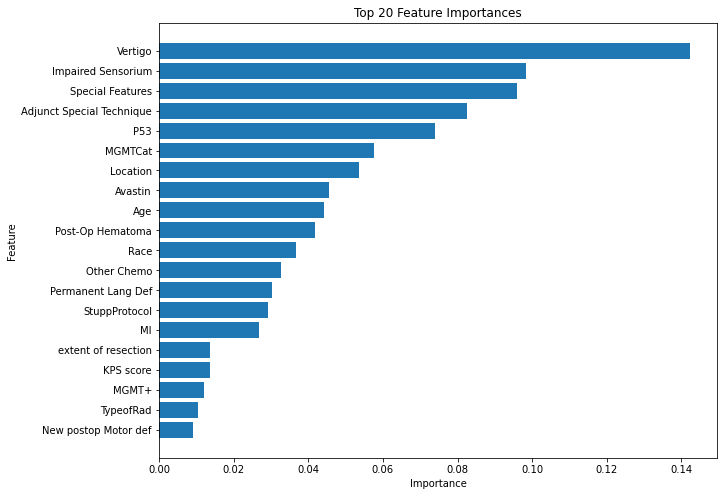

In [ ]:
plt.figure(figsize=(10, 8))
plt.barh(feature_importance['Feature'][:20], feature_importance['Importance'][:20])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 20 Feature Importances')
plt.gca().invert_yaxis()
plt.show()

evaluate the model performance

In [ ]:
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error: {rmse}")
print(feature_importance.head(20))

Root Mean Squared Error: 156.0303592600116
                      Feature  Importance
50                    Vertigo    0.142396
34         Impaired Sensorium    0.098319
22           Special Features    0.095911
62  Adjunct Special Technique    0.082605
11                        P53    0.074044
19                    MGMTCat    0.057659
20                   Location    0.053650
95                    Avastin    0.045669
3                         Age    0.044181
66           Post-Op Hematoma    0.041810
1                        Race    0.036603
98                Other Chemo    0.032778
74         Permanent Lang Def    0.030390
92              StuppProtocol    0.029195
28                         MI    0.026933
23        extent of resection    0.013735
44                  KPS score    0.013725
18                      MGMT+    0.012142
99                  TypeofRad    0.010586
77       New postop Motor def    0.009252
